Keypoints detected
Fundamental Matrix, F : 
 [[ 1.28108523e-03  3.91348843e-03 -4.00743080e-01]
 [-3.79249240e-04 -1.89270399e-03  1.38014025e-01]
 [ 2.47657568e-02 -2.55724342e-01  1.00000000e+00]]


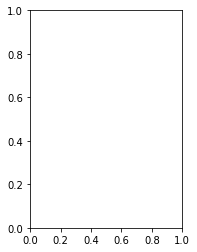

In [51]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import cm
import math


UBIT = 'sdwivedi';
np.random.seed(sum([ord(c) for c in UBIT]))


def outputImage(img, outImageName):
    cv2.imwrite('C:/Users/Shraddha/Desktop/CVIP/HW_Proj_2/OutputImages/'+outImageName+'.jpg', img)
    return 1
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    


img1 = cv2.imread('./proj2_data/data/tsucuba_left.png')
img2 = cv2.imread('./proj2_data/data/tsucuba_right.png')
img1gray= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2gray= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
#detecting the keypoints of image
keypoints1 = sift.detect(img1gray,None)
keypoints2 = sift.detect(img2gray,None)

#drawing a circle according to size of keypoints with its orientation
image1=cv2.drawKeypoints(img1gray,keypoints1,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2=cv2.drawKeypoints(img2gray,keypoints2,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#computing descriptors
keypoints1,descriptors1 = sift.compute(img1gray,keypoints1) 
keypoints2,descriptors2 = sift.compute(img2gray,keypoints2)

print("Keypoints detected")
outputImage(image1,"task2_sift1")
outputImage(image2,"task2_sift2")

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors1,descriptors2,k=2)
good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        good.append(m)
        
        pts2.append(keypoints2[m.trainIdx].pt)
        pts1.append(keypoints1[m.queryIdx].pt)

image3 = cv2.drawMatches(image1,keypoints1,image2,keypoints2,good,None,flags=2)     
outputImage(image3,"task2_matches_knn")
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
pts1 = np.array(random.sample(list(pts1), 10))
pts2 = np.array(random.sample(list(pts2), 10))
# calculating Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1,pts2, cv2.RANSAC, 1,0.99) 
print("Fundamental Matrix, F : \n",F)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts1,pts2, color1):
    
    r,c,v = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = color1
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2, (255,0,0))
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4= drawlines(img2,img1,lines2,pts2,pts1, (55,200,100))
outputImage(img5,"task2_epi_left")
outputImage(img3,"task2_epi_right")

#disparity maps
stereo = cv2.StereoSGBM_create(numDisparities=64, blockSize=27)
disparity = stereo.compute(img1gray,img2gray)
# apply threshold
threshold = cv2.threshold(disparity, 0.6, 1.0, cv2.THRESH_BINARY)[1]

plt.subplot(122),plt.imsave('task2_disparity', disparity, cmap = cm.gray)
plt.show()
